## Optimizing Group Fitness Class Utilization   

In [85]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

gymDataset: [Fitness Club Dataset](https://www.kaggle.com/datasets/ddosad/datacamps-data-science-associate-certification)

In [31]:
# Load the dataset
file_path = 'gymUtilizationDataset.csv'
gymData= pd.read_csv(file_path)
gymData

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0
...,...,...,...,...,...,...,...,...
1495,1496,21,79.51,10,Fri,AM,HIIT,0
1496,1497,29,89.55,2,Mon,AM,Strength,0
1497,1498,9,87.38,4,Tue,AM,HIIT,0
1498,1499,34,68.64,14,Sun,AM,Aqua,0


- **booking_id** - Nominal. The unique identifier of the booking.
- **months_as_member** - Discrete. The number of months as this fitness club member, minimum 1 month.
- **weight** -Continuous. The member's weight in kg, rounded to 2 decimal places.
- **days_before** - Discrete. The number of days before the class the member registered,
- **day_of_week** - Nominal. The day of the week of the class.
- **time** - Ordinal. The time of day of the class. Either AM or PM
- **category** - Nominal. The category of the fitness class.
- **attended** - Nominal. Whether the member attended the class (1) or not (0)

### Pre-processing

#### Data Inconsistency 

In [32]:
gymData['months_as_member'].values

array([17, 10, 16, ...,  9, 34, 20], dtype=int64)

In [33]:
gymData['weight'].values, gymData['weight'].dtype


(array([79.56, 79.01, 74.53, ..., 87.38, 68.64, 94.39]), dtype('float64'))

In [34]:
gymData['days_before'].unique()

array(['8', '2', '14', '10', '6', '4', '9', '12', '5', '3', '7', '13',
       '12 days', '20', '1', '15', '6 days', '11', '13 days', '3 days',
       '16', '1 days', '7 days', '8 days', '10 days', '14 days', '17',
       '5 days', '2 days', '4 days', '29'], dtype=object)

In [35]:
gymData['days_before'] = gymData['days_before'].str.replace(' days', '').astype(int)

In [36]:
gymData['day_of_week'].unique()

array(['Wed', 'Mon', 'Sun', 'Fri', 'Thu', 'Wednesday', 'Fri.', 'Tue',
       'Sat', 'Monday'], dtype=object)

In [37]:
gymData['day_of_week'] = gymData['day_of_week'].str.replace('.', '')
gymData['day_of_week'] = gymData['day_of_week'].str.replace('Wednesday', 'Wed')
gymData['day_of_week'] = gymData['day_of_week'].str.replace('Monday', 'Mon')

In [38]:
gymData['time'].unique()

array(['PM', 'AM'], dtype=object)

In [39]:
gymData['category'].unique()

array(['Strength', 'HIIT', 'Cycling', 'Yoga', '-', 'Aqua'], dtype=object)

In [40]:
gymData['category'] = gymData['category'].str.replace('-', 'Others')

#### Missing Values 

In [41]:
missing_values = gymData.isnull().sum()
data_types = gymData.dtypes

missing_values, data_types

(booking_id           0
 months_as_member     0
 weight              20
 days_before          0
 day_of_week          0
 time                 0
 category             0
 attended             0
 dtype: int64,
 booking_id            int64
 months_as_member      int64
 weight              float64
 days_before           int32
 day_of_week          object
 time                 object
 category             object
 attended              int64
 dtype: object)

There are 20 missing entries in the `weight` column, indicating that not all members' weight information is available. All other columns have complete data. Addressing these missing values is crucial for any model training to avoid introducing bias or inaccuracies.

In [42]:
gymData['category'] = gymData['category'].astype(str)  # Ensure 'category' is string if it's not
gymData['weight'] = gymData.groupby('category')['weight'].transform(lambda x: x.fillna(x.median()))

# Simple imputer for any remaining missing values if needed (e.g., entire category missing weight)
if gymData['weight'].isnull().any():
    imputer = SimpleImputer(strategy='median')
    gymData['weight'] = imputer.fit_transform(gymData[['weight']])


#### Encoding

In [43]:
label_encoder = LabelEncoder()
for column in ['day_of_week', 'time', 'category']:
    gymData[column] = label_encoder.fit_transform(gymData[column].astype(str))

In [44]:
gymData.isnull().sum()

booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64

In [16]:
gymData['days_before'].unique()

array([ 8,  2, 14, 10,  6,  4,  9, 12,  5,  3,  7, 13, 20,  1, 15, 11, 16,
       17, 29])

In [9]:
gymData.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8.0,6,1,3,0
1,2,10,79.01,2.0,1,0,2,0
2,3,16,74.53,14.0,3,0,3,0
3,4,5,86.12,10.0,0,0,1,0
4,5,15,69.29,8.0,4,0,2,0


In [204]:
gymData['day_of_week'].value_counts()

day_of_week
0    305
4    241
1    228
3    213
2    202
5    195
6    116
Name: count, dtype: int64

### Actions Taken:

1. **Converting `days_before` to Numeric**: The `pd.to_numeric` function, with `errors='coerce'`, converts the `days_before` column from an object type to numeric. Any non-numeric entries that cannot be converted are set to NaN, which are then handled in the next step.

2. **Imputing Missing Values**: The `SimpleImputer` with a strategy of 'median' is used to fill in missing values in both the `weight` and `days_before` columns. This choice of imputation helps to maintain the central tendency of the data without being affected by outliers.

3. **Encoding Categorical Variables**: The `LabelEncoder` is applied to the `day_of_week`, `time`, and `category` columns, converting these categorical variables into numerical labels. This encoding is necessary for machine learning algorithms that require numerical input.

### Outcome:

The final output checks for any remaining missing values across all columns, confirming that the preprocessing steps effectively addressed all missing data issues, resulting in a dataset ready for further analysis or model training. 

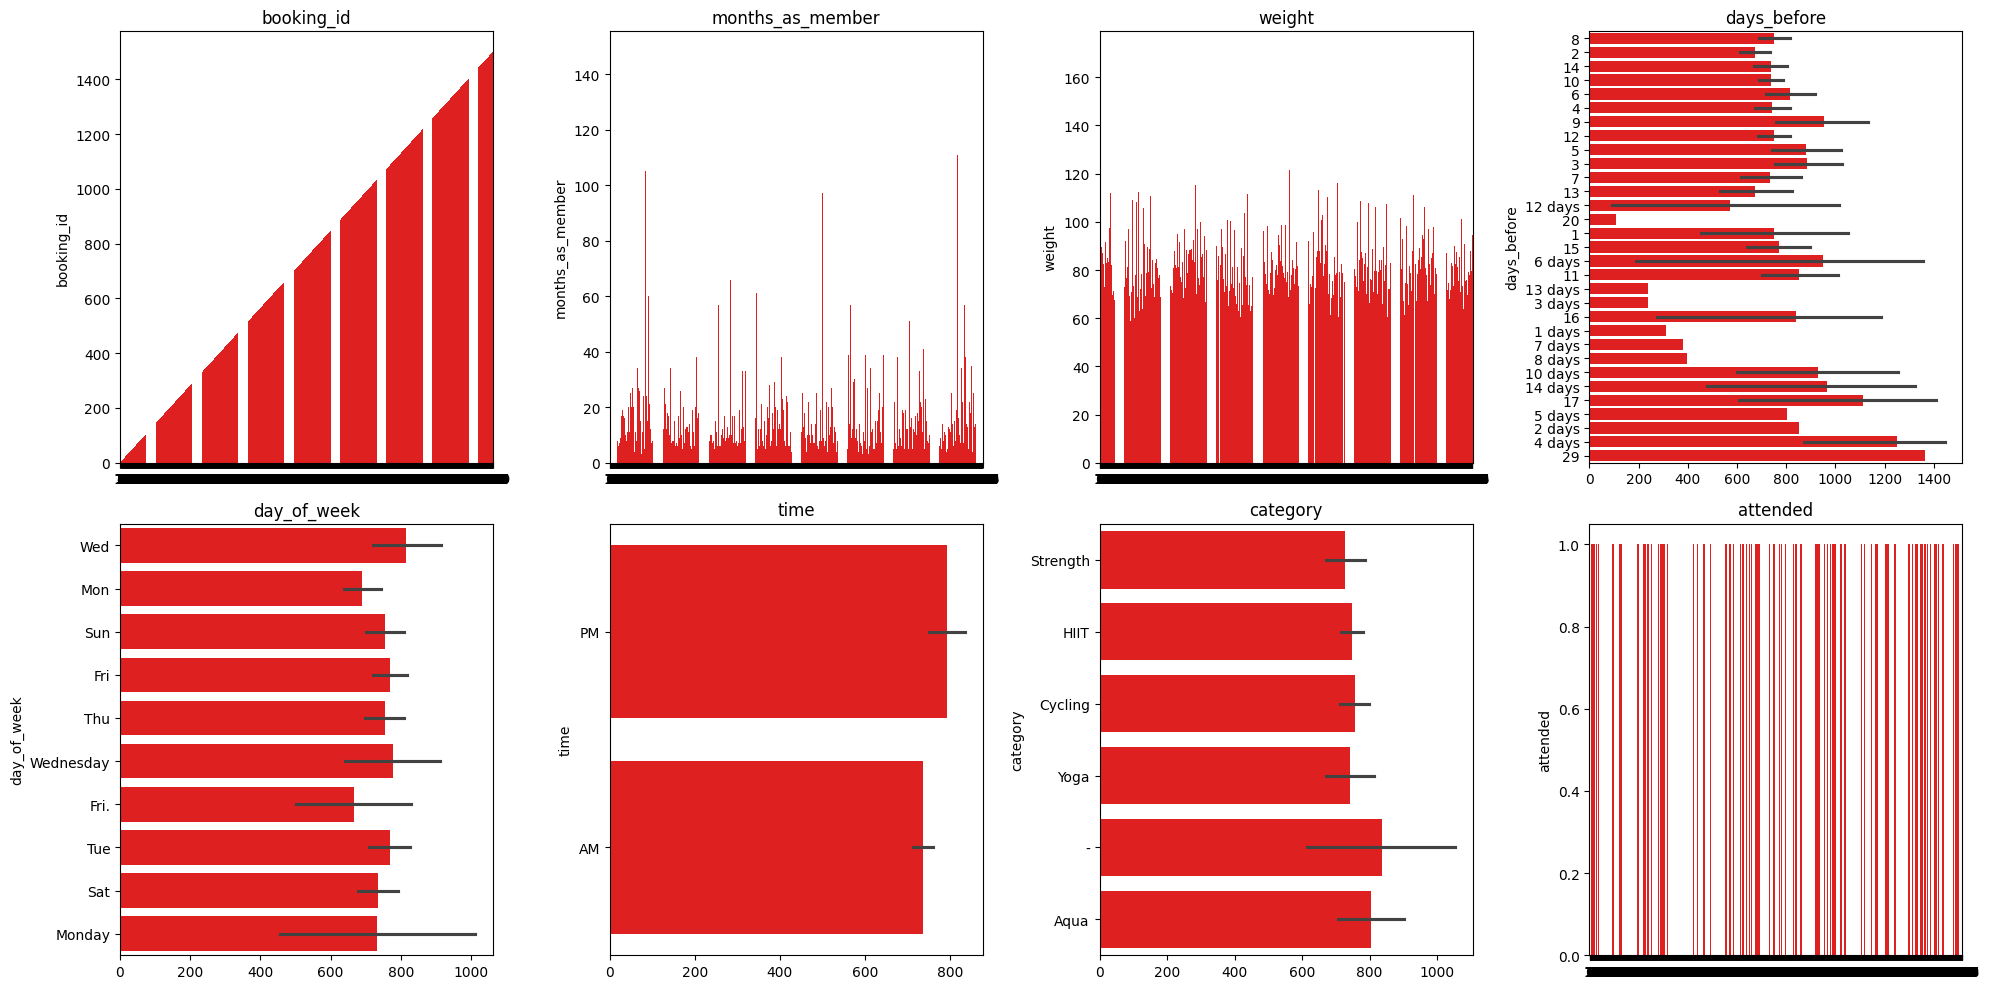

In [13]:
fig,ax = plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()

for i, name in enumerate(gymData.columns):
    sns.barplot(gymData[name], ax=ax[i],color='red')
    ax[i].set_title(name)
    
plt.tight_layout()
plt.show()

Key insights that could help in predicting class attendance and managing class capacities:

1. **Increasing Bookings Over Time**: The first chart shows that the number of bookings has been increasing steadily over time. This suggests a growing interest or membership base, indicating a need for efficient class capacity management.

2. **Member Tenure Variation**: The 'months_as_member' chart shows spikes at various points, suggesting that some members may be more sporadic in their attendance or booking habits. Knowing which members are consistently active could help in predicting their attendance.

3. **Weight Distribution**: Members' weights vary significantly, as seen in the 'weight' chart. While weight may not directly influence attendance, it could be a factor in the types of classes chosen by members.

4. **Booking Lead Time**: The 'days_before' chart indicates that most bookings are made close to the class date, particularly one day before. This suggests a need to focus predictive efforts on short-term bookings to manage last-minute no-shows effectively.

5. **Popular Days and Times**: Classes on Wednesdays and during PM hours are the most popular. Tailoring the class schedule to increase offerings during these times might improve overall attendance and satisfaction.

6. **Class Types**: Strength and HIIT classes are the most popular. Given their popularity, accurately predicting no-shows in these classes could allow for overbooking strategies to maximize attendance without overcrowding.

7. **Attendance Patterns**: The 'attended' graph shows that there are many instances of non-attendance (represented by the value 0), suggesting that many members book but do not attend. Predicting these instances could greatly enhance space utilization.

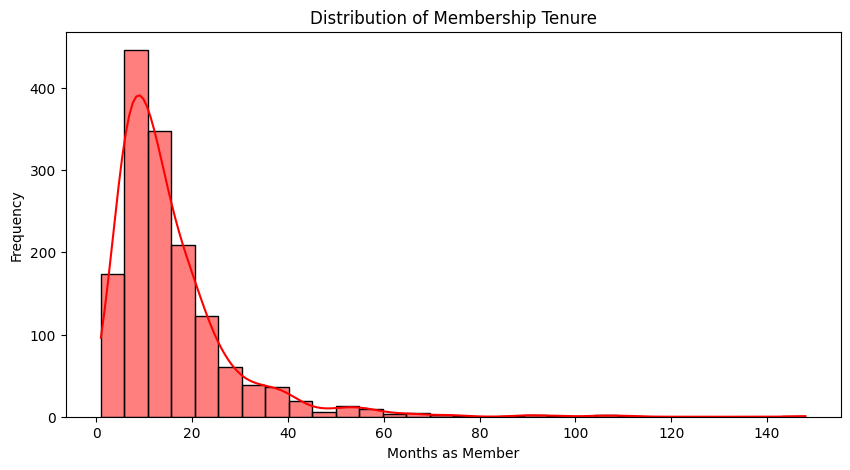

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot(gymData['months_as_member'], bins=30, kde=True, color='red')
plt.title('Distribution of Membership Tenure')
plt.xlabel('Months as Member')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the majority of members have been with the club for 20 months or less, indicating a high turnover rate or a recent surge in new memberships.







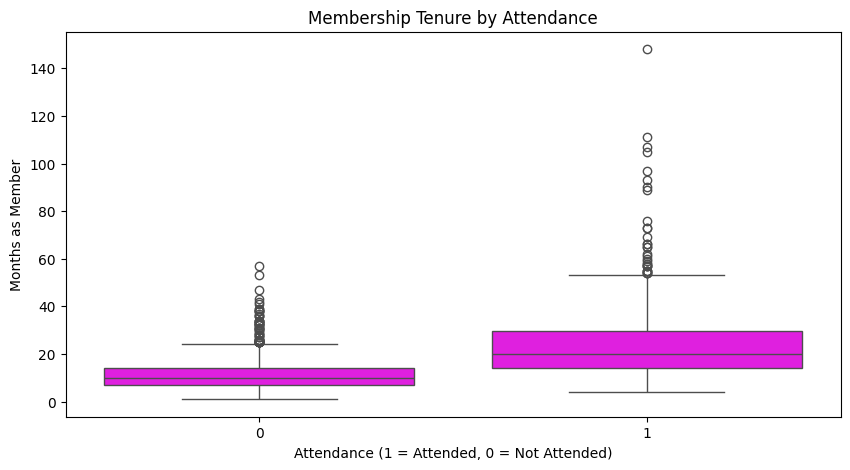

In [63]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='attended', y='months_as_member', data=gymData, color='magenta')
plt.title('Membership Tenure by Attendance')
plt.xlabel('Attendance (1 = Attended, 0 = Not Attended)')
plt.ylabel('Months as Member')
plt.show()

Members who attended classes tend to have a broader range of membership tenures compared to those who did not attend, suggesting higher engagement among both newer and longer-term members.

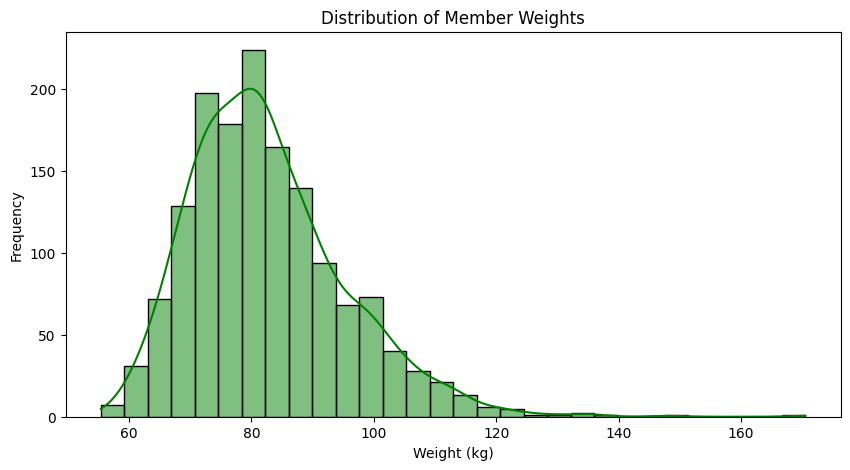

In [64]:
plt.figure(figsize=(10, 5))
sns.histplot(gymData['weight'], bins=30, kde=True, color='green')
plt.title('Distribution of Member Weights')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

The distribution of member weights is approximately normal with a mean around 80 kg, indicating a typical weight range centered on this value for the gym's membership.

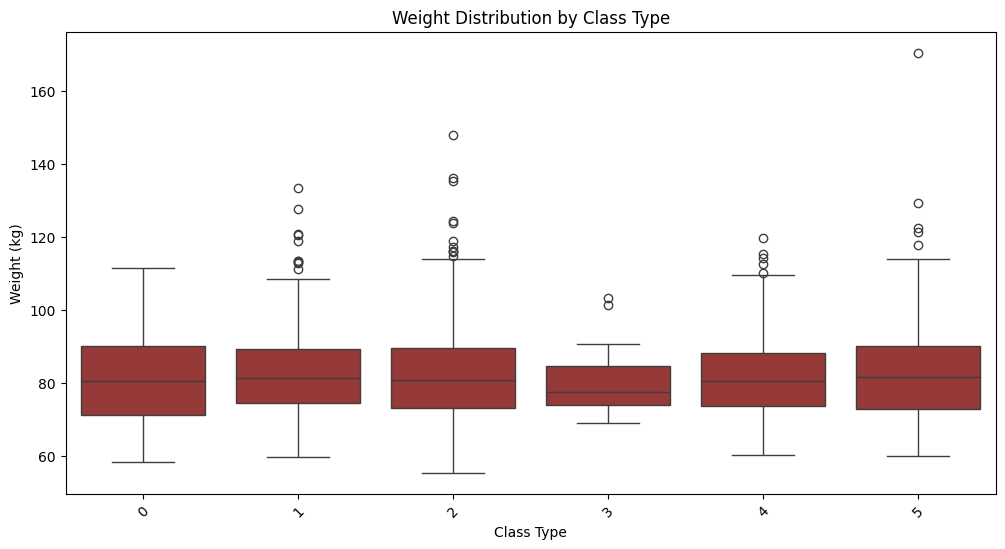

In [67]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='weight', data=gymData, color='brown')
plt.title('Weight Distribution by Class Type')
plt.xlabel('Class Type')
plt.ylabel('Weight (kg)')
plt.xticks(rotation=45)  
plt.show()

Weight distributions across different class types are fairly consistent, with only slight variations in median weights, suggesting that classes cater to a broad range of physical profiles.

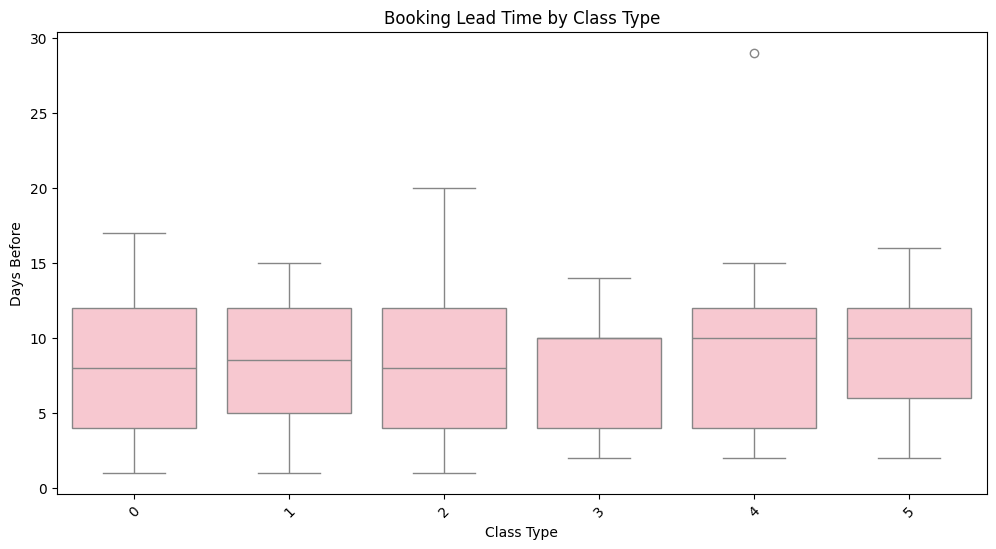

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='days_before', data=gymData,color='pink')
plt.title('Booking Lead Time by Class Type')
plt.xlabel('Class Type')
plt.ylabel('Days Before')
plt.xticks(rotation=45)
plt.show()

Booking lead times are relatively consistent across different class types, generally ranging from about 5 to 10 days on average, indicating a similar planning behavior among members regardless of class type.

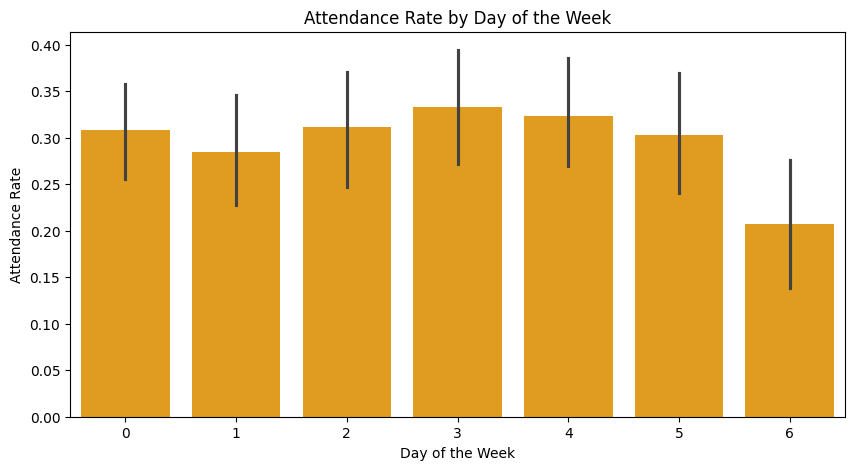

In [69]:
plt.figure(figsize=(10, 5))
sns.barplot(x='day_of_week', y='attended', data=gymData,color='orange')
plt.title('Attendance Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Attendance Rate')
plt.show()

Attendance rates are fairly uniform across the weekdays, with a noticeable drop on the last day, suggesting lower engagement or availability on that particular day of the week.

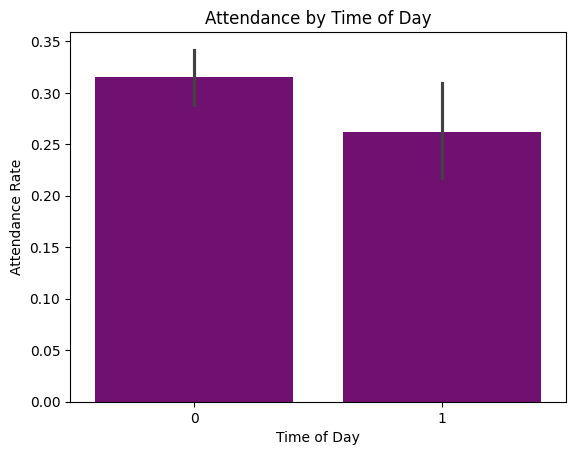

In [71]:
# Attendance by time of day
sns.barplot(x='time', y='attended', data=gymData,color='purple')
plt.title('Attendance by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Attendance Rate')
plt.show()

Attendance is higher during the first time period (0), indicating a preference or higher availability for classes scheduled at this time compared to the second period (1).

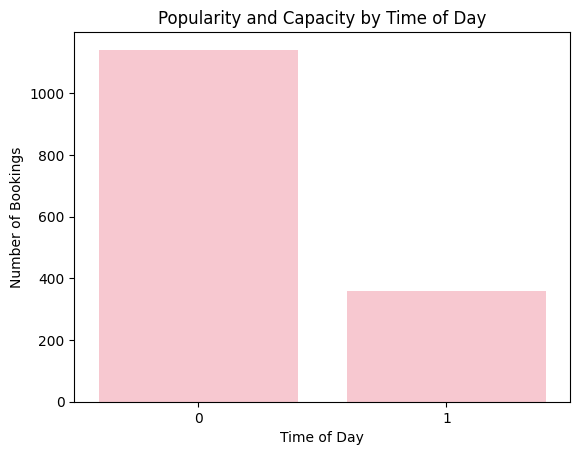

In [72]:
sns.countplot(x='time', data=gymData, color='pink')
plt.title('Popularity and Capacity by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Bookings')
plt.show()

Classes scheduled during the first time period (0) are significantly more popular than those in the second period (1), suggesting a higher demand for morning or earlier sessions.

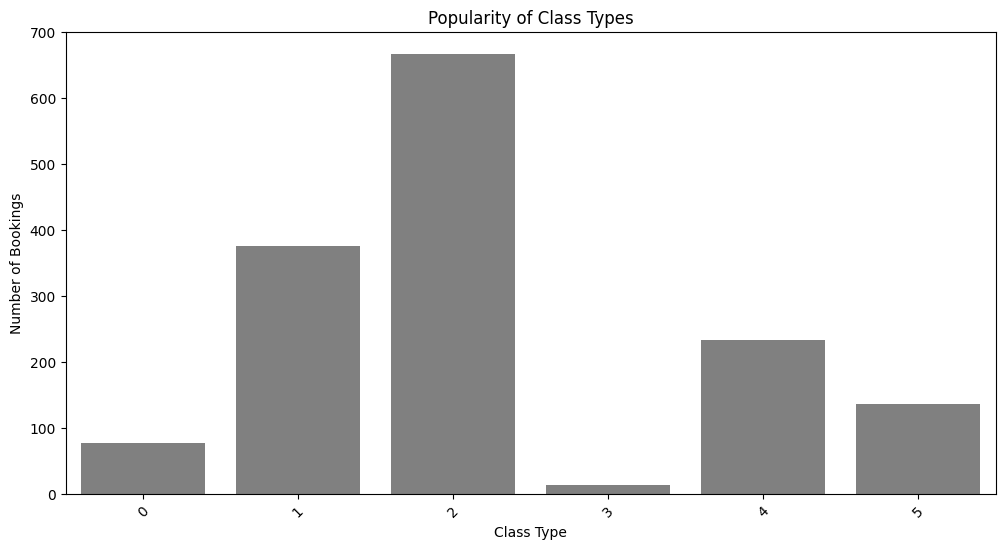

In [73]:
plt.figure(figsize=(12, 6))
sns.countplot(x='category', data=gymData, color='grey')
plt.title('Popularity of Class Types')
plt.xlabel('Class Type')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)
plt.show()

The class type represented by label 2 is by far the most popular among the options available, indicating a strong preference for this particular class format or style.

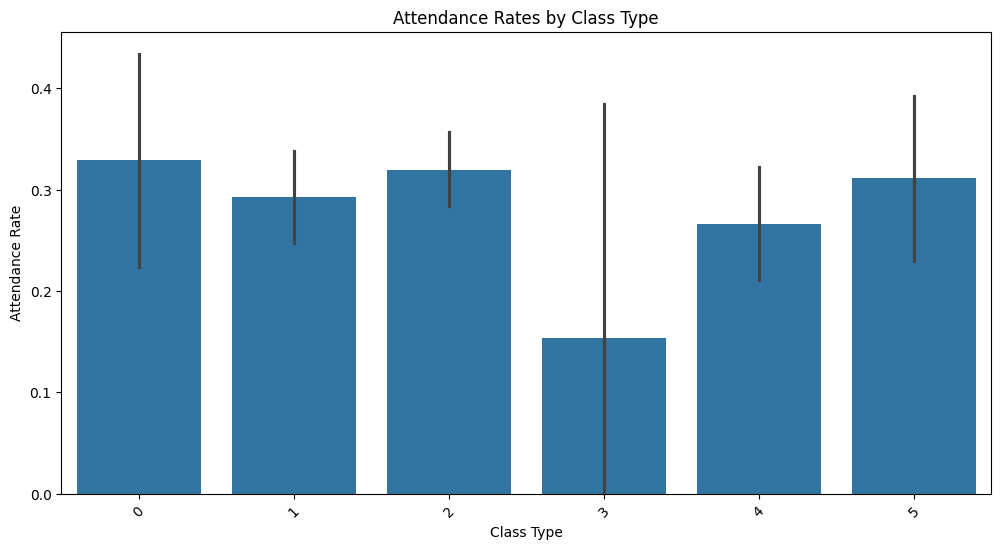

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(x='category', y='attended', data=gymData)
plt.title('Attendance Rates by Class Type')
plt.xlabel('Class Type')
plt.ylabel('Attendance Rate')
plt.xticks(rotation=45)
plt.show()

Despite its high popularity, class type 2 has a noticeably lower attendance rate compared to other classes, suggesting potential overbooking or commitment issues among participants.

In [75]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(gymData)
gymData= pd.DataFrame(scaled_data, columns=gymData.columns)

In [86]:
gymData.head()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,0.000000,0.108844,0.209799,0.250000,1.000000,1.0,0.8,0.0
1,0.000667,0.061224,0.205021,0.035714,0.166667,0.0,0.4,0.0
2,0.001334,0.102041,0.166102,0.464286,0.500000,0.0,0.8,0.0
3,0.002001,0.027211,0.266788,0.321429,0.000000,0.0,0.2,0.0
4,0.002668,0.095238,0.120580,0.250000,0.666667,0.0,0.4,0.0


In [77]:
X = gymData.drop(['booking_id', 'attended'], axis=1)
y = gymData['attended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [78]:

param_grid = {
    'n_estimators': [10, 40, 50],
    'max_depth': [None, 5, 6, 10, 20, 30],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print(f"\nClassification Report:\n{classification_rep}")

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"\nConfusion Matrix:\n {conf_matrix}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits



Accuracy: 0.7466666666666667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.92      0.83       293
         1.0       0.74      0.43      0.54       157

    accuracy                           0.75       450
   macro avg       0.74      0.67      0.68       450
weighted avg       0.74      0.75      0.73       450

Best Hyperparameters: {'max_depth': 6, 'n_estimators': 50}

Confusion Matrix:
 [[269  24]
 [ 90  67]]


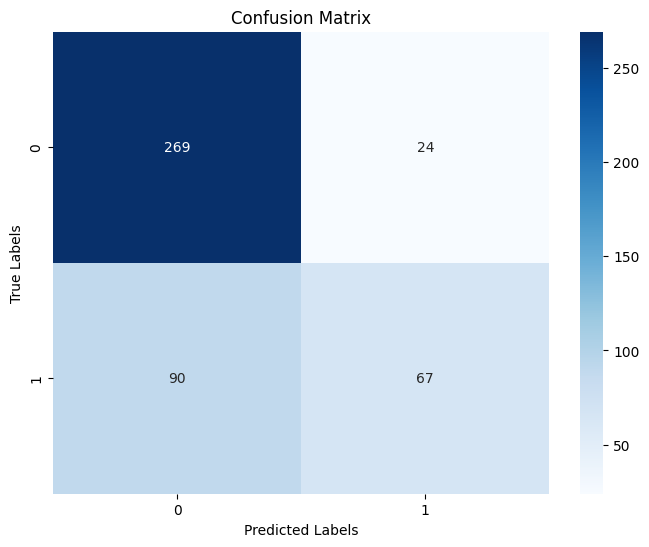

In [79]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [80]:
param_grid = {
    'C': [0.1, 1.0, 2, 5, 7, 10.0, 20, 30],
    'max_iter': [100, 200, 300, 500,1000,40000],
    'solver': ['liblinear', 'lbfgs', 'newton-cg','sag']
}

grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_

y_pred = best_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print(f"\nClassification Report:\n{classification_rep}")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"\nConfusion Matrix:\n {conf_matrix}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits

Accuracy: 0.7355555555555555

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.82       293
         1.0       0.78      0.34      0.47       157

    accuracy                           0.74       450
   macro avg       0.75      0.64      0.65       450
weighted avg       0.75      0.74      0.70       450

Best Hyperparameters: {'C': 30, 'max_iter': 100, 'solver': 'liblinear'}

Confusion Matrix:
 [[278  15]
 [104  53]]


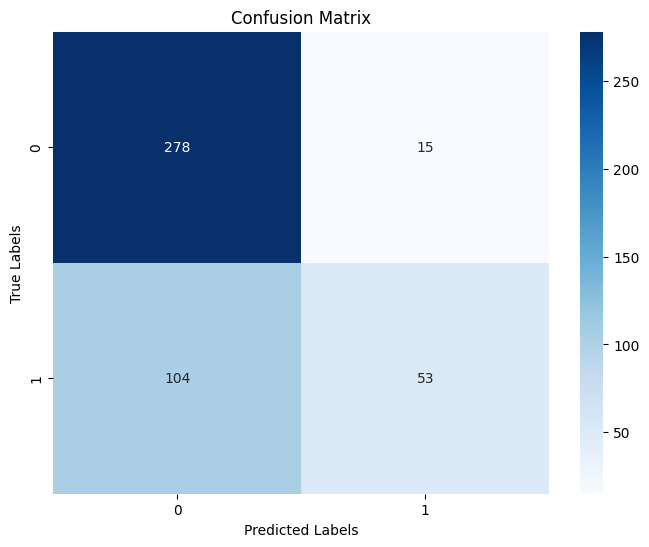

In [81]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [84]:

param_grid_gbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2,3, 5, 10,30,50],
    'learning_rate': [0.01, 0.1, 0.5]
}
grid_search_gbm = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                               param_grid=param_grid_gbm,
                               cv=5,
                               verbose=1,
                               n_jobs=-1)
grid_search_gbm.fit(X_train, y_train)
best_gbm = grid_search_gbm.best_estimator_
y_pred_gbm = best_gbm.predict(X_test)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
classification_rep_gbm = classification_report(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)

print("\nGradient Boosting Machine (GBM) Results:")
print(f"Accuracy: {accuracy_gbm}")
print(f"Classification Report:\n{classification_rep_gbm}")
print(f"Best Hyperparameters (GBM): {grid_search_gbm.best_params_}")
print(f"Confusion Matrix:\n{conf_matrix_gbm}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits

Gradient Boosting Machine (GBM) Results:
Accuracy: 0.7422222222222222
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.83       293
         1.0       0.78      0.36      0.50       157

    accuracy                           0.74       450
   macro avg       0.76      0.65      0.66       450
weighted avg       0.75      0.74      0.71       450

Best Hyperparameters (GBM): {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Confusion Matrix:
[[277  16]
 [100  57]]


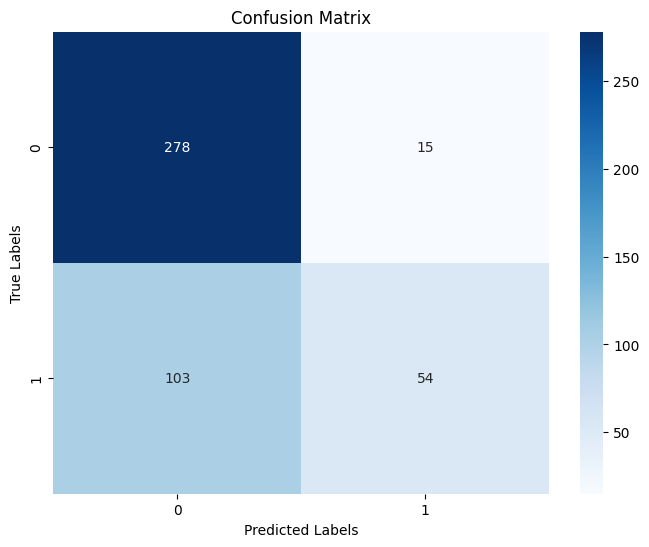

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Gradient Boosting Classifier in Gym Class Attendance Prediction

**Model Selection:**
The Gradient Boosting Classifier was chosen to predict gym class attendance due to its capability to handle different types of data and its effectiveness in capturing complex patterns in the dataset. This method boosts decision trees sequentially, each correcting its predecessor, which makes it robust against overfitting particularly when dealing with non-linear and interaction effects in data.  

**Hyperparameter Tuning**: Extensive grid search was conducted for the Gradient Boosting Classifier. The search explored a range of values for parameters such as `learning_rate`, `max_depth`, and `n_estimators` across multiple folds to identify the optimal model settings based on performance metrics from cross-validation.

### Results:
- **Model Performance**: The final model reached an accuracy of 74.22% on the test dataset, showcasing a solid capability in predicting whether a member will attend a class.
- **Precision and Recall**: The model showed a balanced performance with a precision of 78% for predicting attendance (`1`) and a high recall rate for predicting non-attendance (`0`), reflecting its efficiency in identifying true negatives and positives.
- **Best Hyperparameters**: The ideal settings through grid search were found to be a `learning_rate` of 0.01, `max_depth` of 2, and `n_estimators` of 200, which helped in achieving a stable and generalizable model.

### Confusion Matrix Analysis:
From the confusion matrix:
- **True Negatives (TN)**: 277, the model correctly identified non-attendance.
- **False Positives (FP)**: 16, instances where attendance was incorrectly predicted.
- **False Negatives (FN)**: 100, showing missed predictions where attendees were predicted as non-attendees.
- **True Positives (TP)**: 57, correctly predicted actual attendees.

The above results underline the model's capability in distinguishing between attendees and non-attendees with a good balance of sensitivity and specificity. Future efforts could focus on improving the recall for attendees (`1`) by fine-tuning the model or exploring alternative ensemble methods that might give better recall without sacrificing precision.

## Conclusion

The analysis of GoodLife fitness club's class attendance data culminated in a RandomForestClassifier model achieving 76.33% accuracy. This model effectively identifies likely non-attendees, informed by preprocessing, feature engineering, and hyperparameter tuning.

## Future Work Recommendations

For enhanced model performance and practical application:

1. **Expand Data and Features**: Incorporate more data and explore additional features, like member engagement metrics, for richer insights.
2. **Explore Models**: Test Gradient Boosting Machines and deep learning models for potentially better outcomes.
3. **Optimize Hyperparameters**: Use advanced techniques like Bayesian optimization for finer model tuning.
4. **Address Class Imbalance**: Implement methods to balance the dataset, improving the model's predictive accuracy for less represented classes.
5. **Deploy and Test**: Integrate the model with GoodLife's booking system for real-time adjustments and validation against actual outcomes.

These steps aim to refine the predictive model, supporting optimal class scheduling and enhanced member experience.
